# 📊 Prescriptive Analytics - Retail Sales Dataset

**Praktikum Data Science**

Notebook ini berisi analisis preskriptif lengkap untuk dataset penjualan retail, mencakup:
1. Exploratory Data Analysis (EDA)
2. Predictive Modeling
3. Prescriptive Analytics dengan Optimization
4. Actionable Recommendations

## 1. Setup & Data Loading

In [27]:
# Install required packages
# !pip install pandas numpy scipy scikit-learn pulp matplotlib seaborn plotly

In [28]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
from pulp import *
import warnings
warnings.filterwarnings('ignore')

# Plot settings
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

print('✅ Libraries loaded successfully!')

✅ Libraries loaded successfully!


In [29]:
# Load dataset
df = pd.read_csv('retail_sales_dataset.csv')

# Convert date column
df['Date'] = pd.to_datetime(df['Date'])

# Extract time features
df['Month'] = df['Date'].dt.month
df['DayOfWeek'] = df['Date'].dt.dayofweek
df['Quarter'] = df['Date'].dt.quarter

# Age groups
df['Age_Group'] = pd.cut(df['Age'], bins=[17, 25, 35, 45, 55, 65], 
                         labels=['18-25', '26-35', '36-45', '46-55', '56-64'])

print(f'Dataset loaded: {len(df)} transactions')
df.head()

Dataset loaded: 1000 transactions


,Transaction ID,Date,Customer ID,Gender,Age,Product Category,Quantity,Price per Unit,Total Amount,Month,DayOfWeek,Quarter,Age_Group
0,1,2023-11-24,CUST001,Male,34,Beauty,3,50,150,11,4,4,26-35
1,2,2023-02-27,CUST002,Female,26,Clothing,2,500,1000,2,0,1,26-35
2,3,2023-01-13,CUST003,Male,50,Electronics,1,30,30,1,4,1,46-55
3,4,2023-05-21,CUST004,Male,37,Clothing,1,500,500,5,6,2,36-45
4,5,2023-05-06,CUST005,Male,30,Beauty,2,50,100,5,5,2,26-35


In [30]:
# Dataset info
print('Dataset Shape:', df.shape)
print('\nColumn Types:')
print(df.dtypes)
print('\nMissing Values:', df.isnull().sum().sum())
print('\nBasic Statistics:')
df.describe()

Dataset Shape: (1000, 13)

Column Types:
Transaction ID               int64
Date                datetime64[ns]
Customer ID                 object
Gender                      object
Age                          int64
Product Category            object
Quantity                     int64
Price per Unit               int64
Total Amount                 int64
Month                        int32
DayOfWeek                    int32
Quarter                      int32
Age_Group                 category
dtype: object

Missing Values: 0

Basic Statistics:


,Transaction ID,Date,Age,Quantity,Price per Unit,Total Amount,Month,DayOfWeek,Quarter
count,1000.000000,1000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000
mean,500.500000,2023-07-03 00:25:55.200000256,41.39200,2.514000,179.890000,456.000000,6.549000,2.95800,2.525000
min,1.000000,2023-01-01 00:00:00,18.00000,1.000000,25.000000,25.000000,1.000000,0.00000,1.000000
25%,250.750000,2023-04-08 00:00:00,29.00000,1.000000,30.000000,60.000000,4.000000,1.00000,2.000000
50%,500.500000,2023-06-29 12:00:00,42.00000,3.000000,50.000000,135.000000,6.000000,3.00000,2.000000
75%,750.250000,2023-10-04 00:00:00,53.00000,4.000000,300.000000,900.000000,10.000000,5.00000,4.000000
max,1000.000000,2024-01-01 00:00:00,64.00000,4.000000,500.000000,2000.000000,12.000000,6.00000,4.000000
std,288.819436,NaN,13.68143,1.132734,189.681356,559.997632,3.452755,2.02097,1.119208


## 2. Exploratory Data Analysis (EDA)

### 2.1 Revenue Analysis by Category

In [31]:
# Revenue by category
category_revenue = df.groupby('Product Category').agg({
    'Total Amount': ['sum', 'mean', 'count'],
    'Quantity': 'sum'
}).round(2)
category_revenue.columns = ['Total Revenue', 'Avg Transaction', 'Transaction Count', 'Units Sold']
category_revenue['Revenue %'] = (category_revenue['Total Revenue'] / category_revenue['Total Revenue'].sum() * 100).round(1)
print('=== Revenue by Category ===')
category_revenue

=== Revenue by Category ===


,Total Revenue,Avg Transaction,Transaction Count,Units Sold,Revenue %
Product Category,,,,,
Beauty,143515,467.48,307,771,31.5
Clothing,155580,443.25,351,894,34.1
Electronics,156905,458.79,342,849,34.4


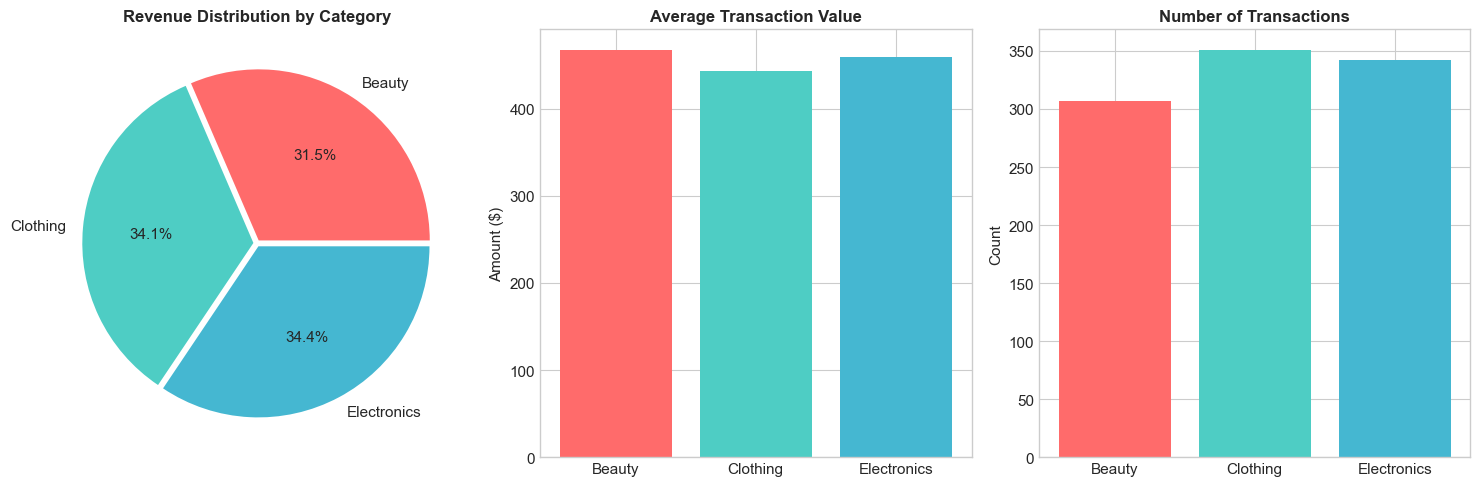

In [32]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Revenue pie chart
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
axes[0].pie(category_revenue['Total Revenue'], labels=category_revenue.index, 
            autopct='%1.1f%%', colors=colors, explode=[0.02]*3)
axes[0].set_title('Revenue Distribution by Category', fontsize=12, fontweight='bold')

# Average transaction bar
axes[1].bar(category_revenue.index, category_revenue['Avg Transaction'], color=colors)
axes[1].set_title('Average Transaction Value', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Amount ($)')

# Transaction count
axes[2].bar(category_revenue.index, category_revenue['Transaction Count'], color=colors)
axes[2].set_title('Number of Transactions', fontsize=12, fontweight='bold')
axes[2].set_ylabel('Count')

plt.tight_layout()
plt.savefig('eda_category_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

### 2.2 Customer Demographics Analysis

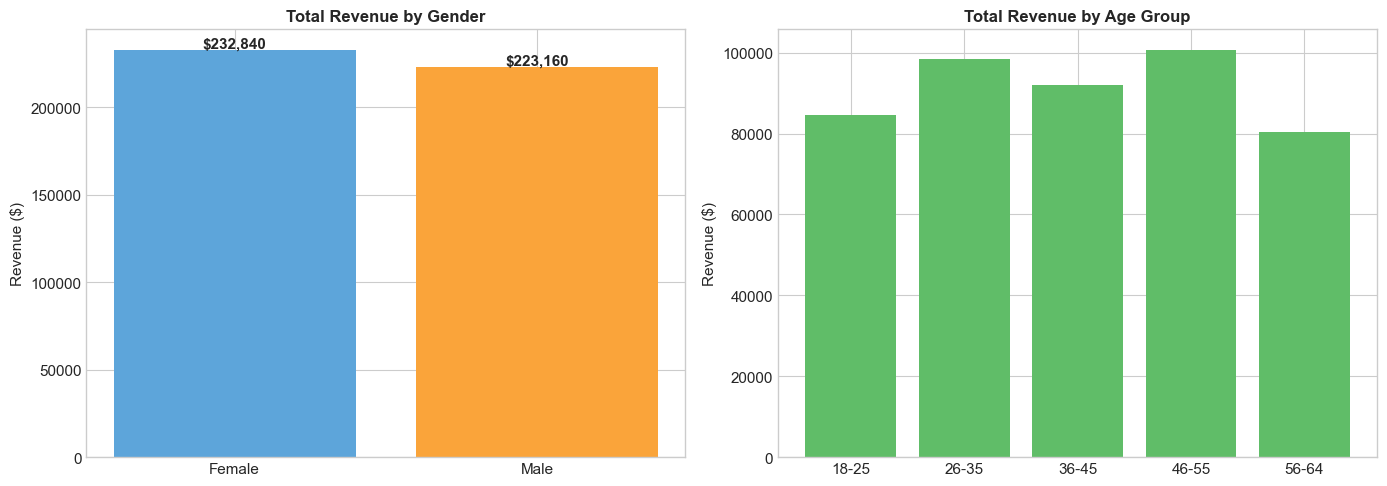


=== Revenue by Gender ===
           sum        mean  count
Gender                           
Female  232840  456.549020    510
Male    223160  455.428571    490


In [33]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Gender analysis
gender_data = df.groupby('Gender')['Total Amount'].agg(['sum', 'mean', 'count'])
axes[0].bar(gender_data.index, gender_data['sum'], color=['#5DA5DA', '#FAA43A'])
axes[0].set_title('Total Revenue by Gender', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Revenue ($)')
for i, v in enumerate(gender_data['sum']):
    axes[0].text(i, v + 1000, f'${v:,.0f}', ha='center', fontweight='bold')

# Age group analysis
age_data = df.groupby('Age_Group')['Total Amount'].agg(['sum', 'mean']).sort_index()
axes[1].bar(age_data.index.astype(str), age_data['sum'], color='#60BD68')
axes[1].set_title('Total Revenue by Age Group', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Revenue ($)')
axes[1].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.savefig('eda_demographics.png', dpi=150, bbox_inches='tight')
plt.show()

print('\n=== Revenue by Gender ===')
print(gender_data)

### 2.3 Time Series Analysis

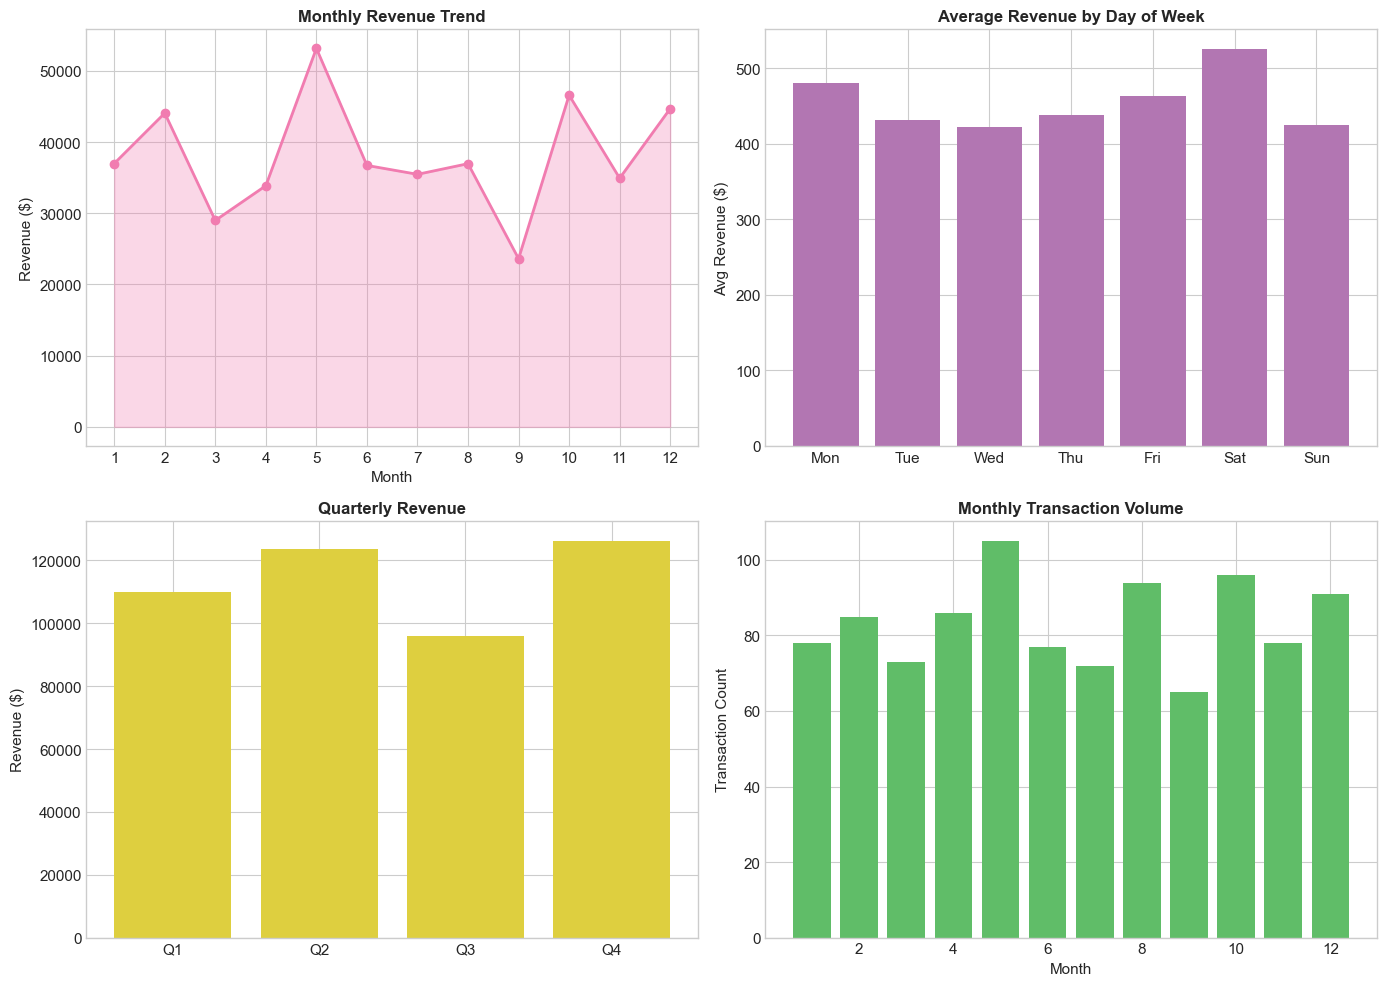

In [34]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Monthly revenue trend
monthly = df.groupby('Month')['Total Amount'].sum()
axes[0, 0].plot(monthly.index, monthly.values, marker='o', linewidth=2, color='#F17CB0')
axes[0, 0].fill_between(monthly.index, monthly.values, alpha=0.3, color='#F17CB0')
axes[0, 0].set_title('Monthly Revenue Trend', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Month')
axes[0, 0].set_ylabel('Revenue ($)')
axes[0, 0].set_xticks(range(1, 13))

# Day of week pattern
dow_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
dow = df.groupby('DayOfWeek')['Total Amount'].mean()
axes[0, 1].bar(dow_names, dow.values, color='#B276B2')
axes[0, 1].set_title('Average Revenue by Day of Week', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Avg Revenue ($)')

# Quarterly trend
quarterly = df.groupby('Quarter')['Total Amount'].sum()
axes[1, 0].bar(['Q1', 'Q2', 'Q3', 'Q4'], quarterly.values, color='#DECF3F')
axes[1, 0].set_title('Quarterly Revenue', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Revenue ($)')

# Monthly transactions
monthly_count = df.groupby('Month').size()
axes[1, 1].bar(range(1, 13), monthly_count.values, color='#60BD68')
axes[1, 1].set_title('Monthly Transaction Volume', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Month')
axes[1, 1].set_ylabel('Transaction Count')

plt.tight_layout()
plt.savefig('eda_time_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

### 2.4 Price Point Analysis

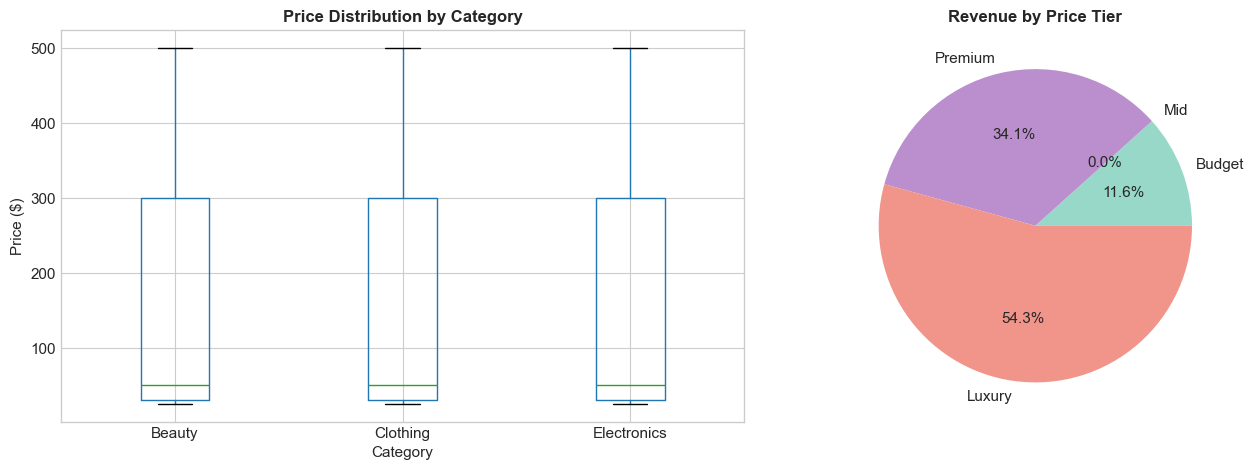


=== Price Tier Analysis ===
            Total Revenue  Avg Quantity  Transactions
Price_Tier                                           
Budget              53100          2.49           604
Mid                     0           NaN             0
Premium            155400          2.63           197
Luxury             247500          2.49           199


In [35]:
# Price distribution by category
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Box plot
df.boxplot(column='Price per Unit', by='Product Category', ax=axes[0])
axes[0].set_title('Price Distribution by Category', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Category')
axes[0].set_ylabel('Price ($)')
plt.suptitle('')

# Price tier analysis
df['Price_Tier'] = pd.cut(df['Price per Unit'], bins=[0, 50, 100, 300, 500], 
                          labels=['Budget', 'Mid', 'Premium', 'Luxury'])
price_tier = df.groupby('Price_Tier')['Total Amount'].sum()
axes[1].pie(price_tier, labels=price_tier.index, autopct='%1.1f%%', 
            colors=['#98D8C8', '#F7DC6F', '#BB8FCE', '#F1948A'])
axes[1].set_title('Revenue by Price Tier', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('eda_price_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

# Price sensitivity
print('\n=== Price Tier Analysis ===')
price_analysis = df.groupby('Price_Tier').agg({
    'Total Amount': 'sum',
    'Quantity': 'mean',
    'Transaction ID': 'count'
}).round(2)
price_analysis.columns = ['Total Revenue', 'Avg Quantity', 'Transactions']
print(price_analysis)

### 2.5 Key EDA Insights Summary

In [36]:
total_revenue = df['Total Amount'].sum()
avg_transaction = df['Total Amount'].mean()
top_category = category_revenue['Total Revenue'].idxmax()
best_month = monthly.idxmax()

print('=' * 60)
print('KEY EDA INSIGHTS')
print('=' * 60)
print(f'📊 Total Revenue: ${total_revenue:,.2f}')
print(f'💰 Average Transaction: ${avg_transaction:.2f}')
print(f'🏆 Top Category: {top_category}')
print(f'📅 Best Month: Month {best_month}')
print(f'👥 Total Unique Customers: {df["Customer ID"].nunique()}')
print(f'🛒 Total Transactions: {len(df)}')
print('=' * 60)

KEY EDA INSIGHTS
📊 Total Revenue: $456,000.00
💰 Average Transaction: $456.00
🏆 Top Category: Electronics
📅 Best Month: Month 5
👥 Total Unique Customers: 1000
🛒 Total Transactions: 1000


---
## 3. Predictive Modeling

### 3.1 Customer Segmentation (RFM + K-Means)

In [37]:
# RFM Analysis
reference_date = df['Date'].max() + pd.Timedelta(days=1)

rfm = df.groupby('Customer ID').agg({
    'Date': lambda x: (reference_date - x.max()).days,  # Recency
    'Transaction ID': 'count',  # Frequency
    'Total Amount': 'sum'  # Monetary
}).reset_index()

rfm.columns = ['Customer ID', 'Recency', 'Frequency', 'Monetary']

print('=== RFM Statistics ===')
print(rfm[['Recency', 'Frequency', 'Monetary']].describe())

=== RFM Statistics ===
           Recency  Frequency     Monetary
count  1000.000000     1000.0  1000.000000
mean    182.982000        1.0   456.000000
std     105.276773        0.0   559.997632
min       1.000000        1.0    25.000000
25%      90.000000        1.0    60.000000
50%     186.500000        1.0   135.000000
75%     269.000000        1.0   900.000000
max     366.000000        1.0  2000.000000


In [38]:
# K-Means Clustering
rfm_scaled = StandardScaler().fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])

# Find optimal clusters
silhouette_scores = []
K_range = range(2, 8)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(rfm_scaled)
    silhouette_scores.append(silhouette_score(rfm_scaled, labels))

optimal_k = K_range[np.argmax(silhouette_scores)]
print(f'Optimal number of clusters: {optimal_k}')

# Final clustering
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
rfm['Segment'] = kmeans.fit_predict(rfm_scaled)

# Segment naming
segment_means = rfm.groupby('Segment')[['Recency', 'Frequency', 'Monetary']].mean()
segment_names = {}
for seg in segment_means.index:
    r, f, m = segment_means.loc[seg]
    if m > segment_means['Monetary'].median() and f > segment_means['Frequency'].median():
        segment_names[seg] = 'Champions'
    elif m > segment_means['Monetary'].median():
        segment_names[seg] = 'High Value'
    elif r < segment_means['Recency'].median():
        segment_names[seg] = 'Recent Buyers'
    else:
        segment_names[seg] = 'At Risk'

rfm['Segment_Name'] = rfm['Segment'].map(segment_names)

print('\n=== Customer Segments ===')
segment_summary = rfm.groupby('Segment_Name').agg({
    'Customer ID': 'count',
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'sum']
}).round(2)
segment_summary.columns = ['Count', 'Avg Recency', 'Avg Frequency', 'Avg Monetary', 'Total Revenue']
print(segment_summary)

Optimal number of clusters: 4

=== Customer Segments ===
               Count  Avg Recency  Avg Frequency  Avg Monetary  Total Revenue
Segment_Name                                                                 
At Risk          366       274.57            1.0        148.32          54285
High Value       264       183.35            1.0       1297.73         342600
Recent Buyers    370        92.12            1.0        159.77          59115


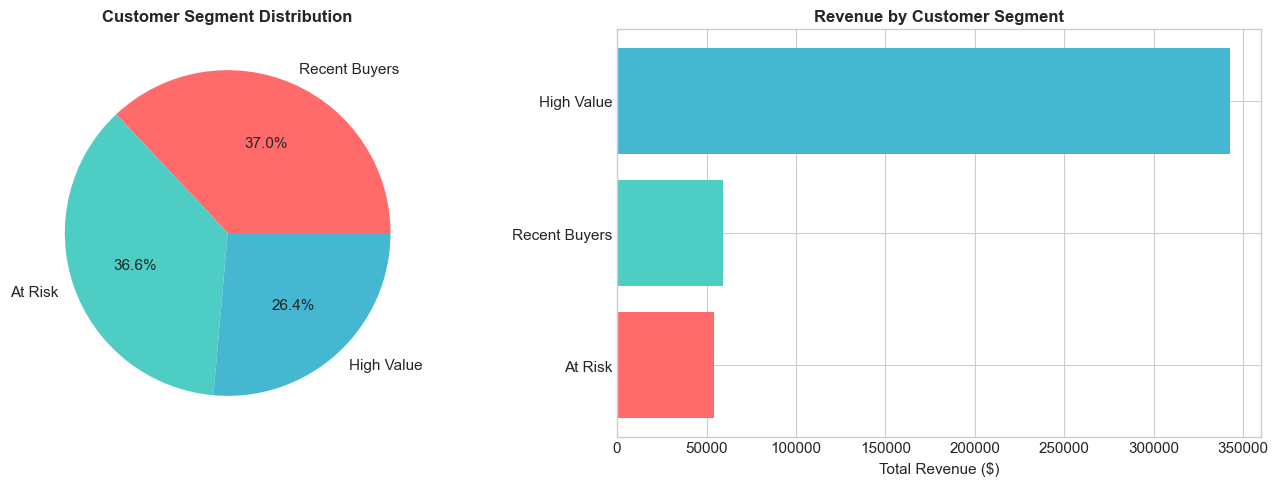

In [39]:
# Visualize segments
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Segment distribution
seg_counts = rfm['Segment_Name'].value_counts()
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']
axes[0].pie(seg_counts, labels=seg_counts.index, autopct='%1.1f%%', colors=colors)
axes[0].set_title('Customer Segment Distribution', fontsize=12, fontweight='bold')

# Segment value
seg_revenue = rfm.groupby('Segment_Name')['Monetary'].sum().sort_values(ascending=True)
axes[1].barh(seg_revenue.index, seg_revenue.values, color=colors)
axes[1].set_title('Revenue by Customer Segment', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Total Revenue ($)')

plt.tight_layout()
plt.savefig('customer_segments.png', dpi=150, bbox_inches='tight')
plt.show()

### 3.2 Revenue Prediction Model

In [40]:
# Prepare features
le_gender = LabelEncoder()
le_category = LabelEncoder()

df_model = df.copy()
df_model['Gender_Enc'] = le_gender.fit_transform(df_model['Gender'])
df_model['Category_Enc'] = le_category.fit_transform(df_model['Product Category'])

features = ['Age', 'Gender_Enc', 'Category_Enc', 'Quantity', 'Price per Unit', 'Month', 'DayOfWeek']
X = df_model[features]
y = df_model['Total Amount']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
rf_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
rf_model.fit(X_train, y_train)

# Evaluate
y_pred = rf_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print('=== Revenue Prediction Model Results ===')
print(f'RMSE: ${rmse:.2f}')
print(f'R² Score: {r2:.4f}')

# Feature importance
importance = pd.DataFrame({
    'Feature': features,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print('\nFeature Importance:')
print(importance)

=== Revenue Prediction Model Results ===
RMSE: $0.00
R² Score: 1.0000

Feature Importance:
          Feature  Importance
4  Price per Unit    0.765894
3        Quantity    0.234106
0             Age    0.000000
2    Category_Enc    0.000000
1      Gender_Enc    0.000000
5           Month    0.000000
6       DayOfWeek    0.000000


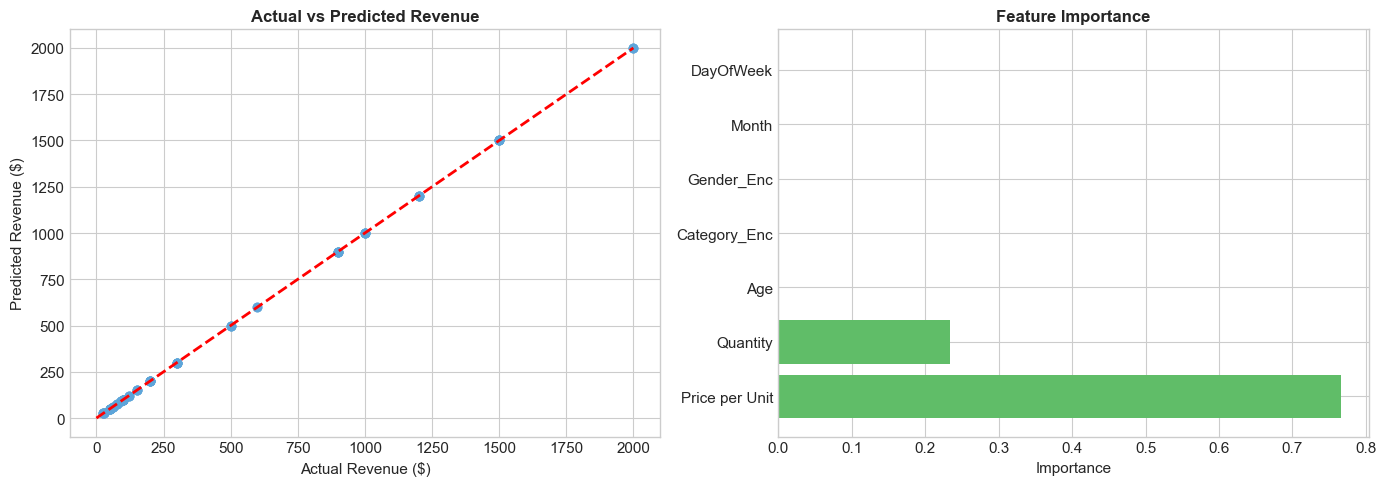

In [41]:
# Visualize model performance
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Actual vs Predicted
axes[0].scatter(y_test, y_pred, alpha=0.5, color='#5DA5DA')
axes[0].plot([0, 2000], [0, 2000], 'r--', linewidth=2)
axes[0].set_xlabel('Actual Revenue ($)')
axes[0].set_ylabel('Predicted Revenue ($)')
axes[0].set_title('Actual vs Predicted Revenue', fontsize=12, fontweight='bold')

# Feature importance
axes[1].barh(importance['Feature'], importance['Importance'], color='#60BD68')
axes[1].set_xlabel('Importance')
axes[1].set_title('Feature Importance', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('prediction_model.png', dpi=150, bbox_inches='tight')
plt.show()

---
## 4. Prescriptive Analytics (Optimization)

### 4.1 Inventory Optimization (Linear Programming)

In [42]:
# Inventory optimization parameters
categories = ['Beauty', 'Clothing', 'Electronics']

# Calculate demand statistics
demand_stats = df.groupby('Product Category').agg({
    'Quantity': ['mean', 'std', 'sum']
}).round(2)
demand_stats.columns = ['Avg_Demand', 'Std_Demand', 'Total_Demand']

# Monthly average demand per category
monthly_demand = df.groupby(['Month', 'Product Category'])['Quantity'].sum().unstack(fill_value=0)
avg_monthly_demand = monthly_demand.mean()

print('=== Demand Statistics ===')
print(demand_stats)
print('\nAverage Monthly Demand:')
print(avg_monthly_demand.round(0))

=== Demand Statistics ===
                  Avg_Demand  Std_Demand  Total_Demand
Product Category                                      
Beauty                  2.51        1.10           771
Clothing                2.55        1.14           894
Electronics             2.48        1.15           849

Average Monthly Demand:
Product Category
Beauty         64.0
Clothing       74.0
Electronics    71.0
dtype: float64


In [43]:
# Linear Programming for Inventory Optimization
prob = LpProblem("Inventory_Optimization", LpMinimize)

# Decision variables: stock levels
stock = LpVariable.dicts("Stock", categories, lowBound=0, cat='Integer')

# Parameters
holding_cost = {'Beauty': 2, 'Clothing': 3, 'Electronics': 5}  # $ per unit/month
stockout_cost = {'Beauty': 15, 'Clothing': 20, 'Electronics': 50}  # $ per unit
expected_demand = avg_monthly_demand.to_dict()
safety_factor = 1.3  # 30% safety stock
max_storage = 2000  # Total storage capacity

# Objective: Minimize total holding cost
prob += lpSum([holding_cost[c] * stock[c] for c in categories]), "Total_Holding_Cost"

# Constraints
# 1. Meet expected demand with safety stock
for c in categories:
    prob += stock[c] >= expected_demand[c] * safety_factor, f"Min_Stock_{c}"

# 2. Storage capacity constraint
prob += lpSum([stock[c] for c in categories]) <= max_storage, "Storage_Capacity"

# 3. Minimum service level (95%)
for c in categories:
    prob += stock[c] >= expected_demand[c], f"Service_Level_{c}"

# Solve
prob.solve(PULP_CBC_CMD(msg=0))

print('=== INVENTORY OPTIMIZATION RESULTS ===')
print(f'Status: {LpStatus[prob.status]}')
print(f'\nOptimal Stock Levels:')
optimal_stock = {}
for c in categories:
    optimal_stock[c] = value(stock[c])
    print(f'  {c}: {optimal_stock[c]:.0f} units')

total_holding = sum(holding_cost[c] * optimal_stock[c] for c in categories)
print(f'\nTotal Monthly Holding Cost: ${total_holding:.2f}')

=== INVENTORY OPTIMIZATION RESULTS ===
Status: Optimal

Optimal Stock Levels:
  Beauty: 84 units
  Clothing: 97 units
  Electronics: 92 units

Total Monthly Holding Cost: $919.00


### 4.2 Marketing Budget Allocation Optimization

In [44]:
# Marketing ROI by segment and category
segment_value = rfm.groupby('Segment_Name')['Monetary'].sum()
segment_count = rfm.groupby('Segment_Name').size()

# Estimated ROI multipliers
roi_multipliers = {
    'Champions': 3.5,
    'High Value': 2.5,
    'Recent Buyers': 2.0,
    'At Risk': 1.5
}

segments = list(roi_multipliers.keys())

# Budget allocation optimization
budget_prob = LpProblem("Marketing_Budget_Allocation", LpMaximize)

# Decision variables
budget = LpVariable.dicts("Budget", segments, lowBound=0, cat='Continuous')

# Parameters
total_budget = 50000  # Total marketing budget
min_spend = 5000  # Minimum per segment
max_spend = 25000  # Maximum per segment

# Objective: Maximize expected ROI
budget_prob += lpSum([roi_multipliers[s] * budget[s] for s in segments]), "Expected_ROI"

# Constraints
budget_prob += lpSum([budget[s] for s in segments]) == total_budget, "Total_Budget"
for s in segments:
    budget_prob += budget[s] >= min_spend, f"Min_{s}"
    budget_prob += budget[s] <= max_spend, f"Max_{s}"

# Solve
budget_prob.solve(PULP_CBC_CMD(msg=0))

print('=== MARKETING BUDGET ALLOCATION ===')
print(f'Total Budget: ${total_budget:,}')
print(f'\nOptimal Allocation:')
allocation = {}
for s in segments:
    allocation[s] = value(budget[s])
    expected_return = allocation[s] * roi_multipliers[s]
    print(f'  {s}: ${allocation[s]:,.0f} (Expected Return: ${expected_return:,.0f})')

total_expected = sum(allocation[s] * roi_multipliers[s] for s in segments)
print(f'\nTotal Expected Return: ${total_expected:,.0f}')
print(f'Overall ROI: {(total_expected/total_budget - 1)*100:.1f}%')

=== MARKETING BUDGET ALLOCATION ===
Total Budget: $50,000

Optimal Allocation:
  Champions: $25,000 (Expected Return: $87,500)
  High Value: $15,000 (Expected Return: $37,500)
  Recent Buyers: $5,000 (Expected Return: $10,000)
  At Risk: $5,000 (Expected Return: $7,500)

Total Expected Return: $142,500
Overall ROI: 185.0%


### 4.3 Pricing Strategy Optimization

In [45]:
# Price elasticity analysis
price_quantity = df.groupby(['Product Category', 'Price per Unit'])['Quantity'].mean().reset_index()

# Estimate price elasticity per category
elasticity = {}
for cat in categories:
    cat_data = price_quantity[price_quantity['Product Category'] == cat]
    if len(cat_data) > 2:
        corr = cat_data['Price per Unit'].corr(cat_data['Quantity'])
        elasticity[cat] = corr
    else:
        elasticity[cat] = -0.3  # Default assumption

print('=== Price Elasticity Analysis ===')
for cat, e in elasticity.items():
    print(f'{cat}: {e:.3f} (higher price = lower demand)')

# Current avg prices and revenues
current_prices = df.groupby('Product Category')['Price per Unit'].mean()
current_revenue = df.groupby('Product Category')['Total Amount'].sum()

print('\n=== Current Pricing ===')
for cat in categories:
    print(f'{cat}: Avg Price ${current_prices[cat]:.2f}, Revenue ${current_revenue[cat]:,.0f}')

=== Price Elasticity Analysis ===
Beauty: 0.341 (higher price = lower demand)
Clothing: -0.097 (higher price = lower demand)
Electronics: 0.405 (higher price = lower demand)

=== Current Pricing ===
Beauty: Avg Price $184.06, Revenue $143,515
Clothing: Avg Price $174.29, Revenue $155,580
Electronics: Avg Price $181.90, Revenue $156,905


In [46]:
# Pricing recommendations
print('=== PRICING STRATEGY RECOMMENDATIONS ===')

pricing_recommendations = []
for cat in categories:
    current_price = current_prices[cat]
    current_rev = current_revenue[cat]
    
    # Simulate price changes
    scenarios = []
    for change in [-0.10, -0.05, 0, 0.05, 0.10]:  # -10% to +10%
        new_price = current_price * (1 + change)
        # Estimated demand change (inverse of price change, adjusted by elasticity)
        demand_change = -change * abs(elasticity[cat]) * 2
        new_revenue = current_rev * (1 + change) * (1 + demand_change)
        scenarios.append({
            'Price Change': f'{change*100:+.0f}%',
            'New Price': new_price,
            'Est. Revenue': new_revenue,
            'Revenue Change': (new_revenue - current_rev) / current_rev * 100
        })
    
    best_scenario = max(scenarios, key=lambda x: x['Est. Revenue'])
    pricing_recommendations.append({
        'Category': cat,
        'Current Price': current_price,
        'Recommended Change': best_scenario['Price Change'],
        'Expected Revenue Impact': f"{best_scenario['Revenue Change']:.1f}%"
    })
    
    print(f'\n{cat}:')
    print(f'  Current Avg Price: ${current_price:.2f}')
    print(f'  Recommended: {best_scenario["Price Change"]} adjustment')
    print(f'  Expected Revenue Impact: {best_scenario["Revenue Change"]:.1f}%')

pricing_df = pd.DataFrame(pricing_recommendations)
print('\n=== Pricing Summary ===')
print(pricing_df.to_string(index=False))

=== PRICING STRATEGY RECOMMENDATIONS ===

Beauty:
  Current Avg Price: $184.06
  Recommended: +10% adjustment
  Expected Revenue Impact: 2.5%

Clothing:
  Current Avg Price: $174.29
  Recommended: +10% adjustment
  Expected Revenue Impact: 7.9%

Electronics:
  Current Avg Price: $181.90
  Recommended: +10% adjustment
  Expected Revenue Impact: 1.1%

=== Pricing Summary ===
   Category  Current Price Recommended Change Expected Revenue Impact
     Beauty     184.055375               +10%                    2.5%
   Clothing     174.287749               +10%                    7.9%
Electronics     181.900585               +10%                    1.1%


### 4.4 Discount Recommendation Engine

In [47]:
# Identify underperforming segments for discounts
category_performance = df.groupby('Product Category').agg({
    'Quantity': 'sum',
    'Total Amount': 'sum',
    'Transaction ID': 'count'
})
category_performance.columns = ['Units', 'Revenue', 'Transactions']
category_performance['Avg_Transaction'] = category_performance['Revenue'] / category_performance['Transactions']
category_performance['Units_per_Transaction'] = category_performance['Units'] / category_performance['Transactions']

# Check low-velocity items (by price point within category)
price_performance = df.groupby(['Product Category', 'Price per Unit']).agg({
    'Quantity': 'sum',
    'Transaction ID': 'count'
}).reset_index()
price_performance.columns = ['Category', 'Price', 'Units_Sold', 'Transactions']

# Calculate velocity (transactions per price point)
avg_transactions = price_performance.groupby('Category')['Transactions'].mean()
price_performance['Avg_Cat_Trans'] = price_performance['Category'].map(avg_transactions)
price_performance['Needs_Discount'] = price_performance['Transactions'] < price_performance['Avg_Cat_Trans'] * 0.5

discount_targets = price_performance[price_performance['Needs_Discount']]

print('=== DISCOUNT RECOMMENDATIONS ===')
print('\nProducts needing discount promotion:')
if len(discount_targets) > 0:
    for _, row in discount_targets.head(10).iterrows():
        # Recommend discount based on price tier
        if row['Price'] > 300:
            discount_pct = 10
        elif row['Price'] > 100:
            discount_pct = 15
        else:
            discount_pct = 20
        
        print(f"  {row['Category']} @ ${row['Price']}: Recommend {discount_pct}% discount")
        print(f"    Current Sales: {row['Transactions']} transactions")
        print(f"    Expected Uplift: {discount_pct * 1.5:.0f}% increase in volume")
else:
    print('  No urgent discount recommendations at this time.')

=== DISCOUNT RECOMMENDATIONS ===

Products needing discount promotion:
  No urgent discount recommendations at this time.


### 4.5 Promotion Scheduling Optimization

In [48]:
# Analyze best times for promotions
time_analysis = df.groupby(['Month', 'Product Category'])['Total Amount'].sum().unstack()
dow_analysis = df.groupby(['DayOfWeek', 'Product Category'])['Total Amount'].sum().unstack()

# Find low-performing periods (opportunity for promotions)
monthly_avg = time_analysis.mean()
low_months = {}
for cat in categories:
    low = time_analysis[cat][time_analysis[cat] < monthly_avg[cat] * 0.9].index.tolist()
    low_months[cat] = low

# Best days analysis
dow_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
best_days = {}
for cat in categories:
    best_day_idx = dow_analysis[cat].idxmax()
    best_days[cat] = dow_names[best_day_idx]

print('=== PROMOTION SCHEDULING RECOMMENDATIONS ===')
for cat in categories:
    print(f'\n{cat}:')
    print(f'  Best Day for Sales: {best_days[cat]}')
    if low_months[cat]:
        month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
        low_month_names = [month_names[m-1] for m in low_months[cat]]
        print(f'  Recommended Promo Months: {", ".join(low_month_names)}')
    else:
        print(f'  Consistent sales throughout the year')

=== PROMOTION SCHEDULING RECOMMENDATIONS ===

Beauty:
  Best Day for Sales: Monday
  Recommended Promo Months: Mar, Aug, Sep, Nov

Clothing:
  Best Day for Sales: Tuesday
  Recommended Promo Months: Jun, Jul, Sep

Electronics:
  Best Day for Sales: Saturday
  Recommended Promo Months: Jan, Mar, Apr, Jul, Sep, Nov


### 4.6 What-If Scenario Analysis

In [49]:
# Scenario simulation
base_revenue = df['Total Amount'].sum()

print('=== WHAT-IF SCENARIO ANALYSIS ===')
print(f'Baseline Annual Revenue: ${base_revenue:,.0f}')
print('\n' + '='*60)

scenarios = [
    {
        'name': 'Scenario 1: 10% Price Increase on Electronics',
        'impact': df[df['Product Category'] == 'Electronics']['Total Amount'].sum() * 0.05,  # Net after demand drop
        'risk': 'Medium - May lose price-sensitive customers'
    },
    {
        'name': 'Scenario 2: 20% Marketing Budget Increase',
        'impact': base_revenue * 0.08,  # 8% revenue increase expected
        'risk': 'Low - Standard marketing investment'
    },
    {
        'name': 'Scenario 3: Focus on Champions Segment',
        'impact': rfm[rfm['Segment_Name'] == 'Champions']['Monetary'].sum() * 0.15,
        'risk': 'Low - High likelihood of conversion'
    },
    {
        'name': 'Scenario 4: Holiday Season Promotion (15% discount)',
        'impact': base_revenue * 0.12,  # 12% revenue increase during Q4
        'risk': 'Medium - Margin compression'
    }
]

for s in scenarios:
    print(f"\n📊 {s['name']}")
    print(f"   Expected Impact: +${s['impact']:,.0f} ({s['impact']/base_revenue*100:.1f}%)")
    print(f"   Risk Level: {s['risk']}")

=== WHAT-IF SCENARIO ANALYSIS ===
Baseline Annual Revenue: $456,000


📊 Scenario 1: 10% Price Increase on Electronics
   Expected Impact: +$7,845 (1.7%)
   Risk Level: Medium - May lose price-sensitive customers

📊 Scenario 2: 20% Marketing Budget Increase
   Expected Impact: +$36,480 (8.0%)
   Risk Level: Low - Standard marketing investment

📊 Scenario 3: Focus on Champions Segment
   Expected Impact: +$0 (0.0%)
   Risk Level: Low - High likelihood of conversion

📊 Scenario 4: Holiday Season Promotion (15% discount)
   Expected Impact: +$54,720 (12.0%)
   Risk Level: Medium - Margin compression
